In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped;
# assignment folder, e.g. 'comp411/assignments/assignment1/'
FOLDERNAME = 'Fall24/Comp430/Proje'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Fall24/Comp430/Proje


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline
import matplotlib.pyplot as plt
import os
print(os.listdir("samples"))

# Any results you write to the current directory are saved as output.

['6c3p5.png', 'enpw2.png', 'cb8cf.png', '68x48.png', '5wddw.png', '28348.png', '3bfnd.png', 'ddcne.png', '3fbxd.png', '6ecbn.png', '4nnf3.png', '6f857.png', 'cg5dd.png', 'd236n.png', 'cdfen.png', 'dbpcd.png', '24f6w.png', 'b26nd.png', 'dn26n.png', 'ccf2w.png', 'd378n.png', '244e2.png', 'c4527.png', '4743p.png', 'b5dn4.png', 'efb3f.png', 'bgxcd.jpg', 'b3xpn.png', '7634y.png', 'f753f.png', '8bbw8.png', 'cwgyx.png', '245y5.png', 'dpbyd.png', 'dmx8p.png', '66wp5.png', '7d44m.png', 'e46yw.png', '5yxgp.png', 'ec6pm.png', 'ddxpp.jpg', '8w754.png', '4ycex.png', 'de45x.png', '658xe.png', 'dn2ym.png', '264m5.png', '46mbm.png', '8e32m.png', 'exycn.png', '64b3p.png', '6mege.png', '7gmf3.png', '8d4wm.png', 'bgb48.png', 'f35xp.png', '3w2bw.png', '6ydyp.png', '5dxnm.png', 'e3ndn.png', 'dw8d3.png', '5nxnn.png', 'f6ww8.png', '82fx2.png', 'e4gd7.png', '6cwxe.png', 'ef4mn.png', 'e43ym.png', 'e7x45.png', '55w5c.png', 'bbymy.png', '4egem.png', 'f5e5e.png', '8n5pn.png', 'd8xcn.png', '5n732.png', 'c753e.png'

In [ ]:
from keras import layers
from keras.models import Model
from keras.models import load_model
import tensorflow.keras.utils as utils
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [ ]:
print(num_symbols)

36


In [ ]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7

    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)

    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
def preprocess_data():
    n_samples = len(os.listdir('samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs

    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [ ]:
print(len(X))

1070


In [ ]:
model=create_model();
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 50, 200, 16)          160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 25, 100, 16)          0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d_3[0][0]'

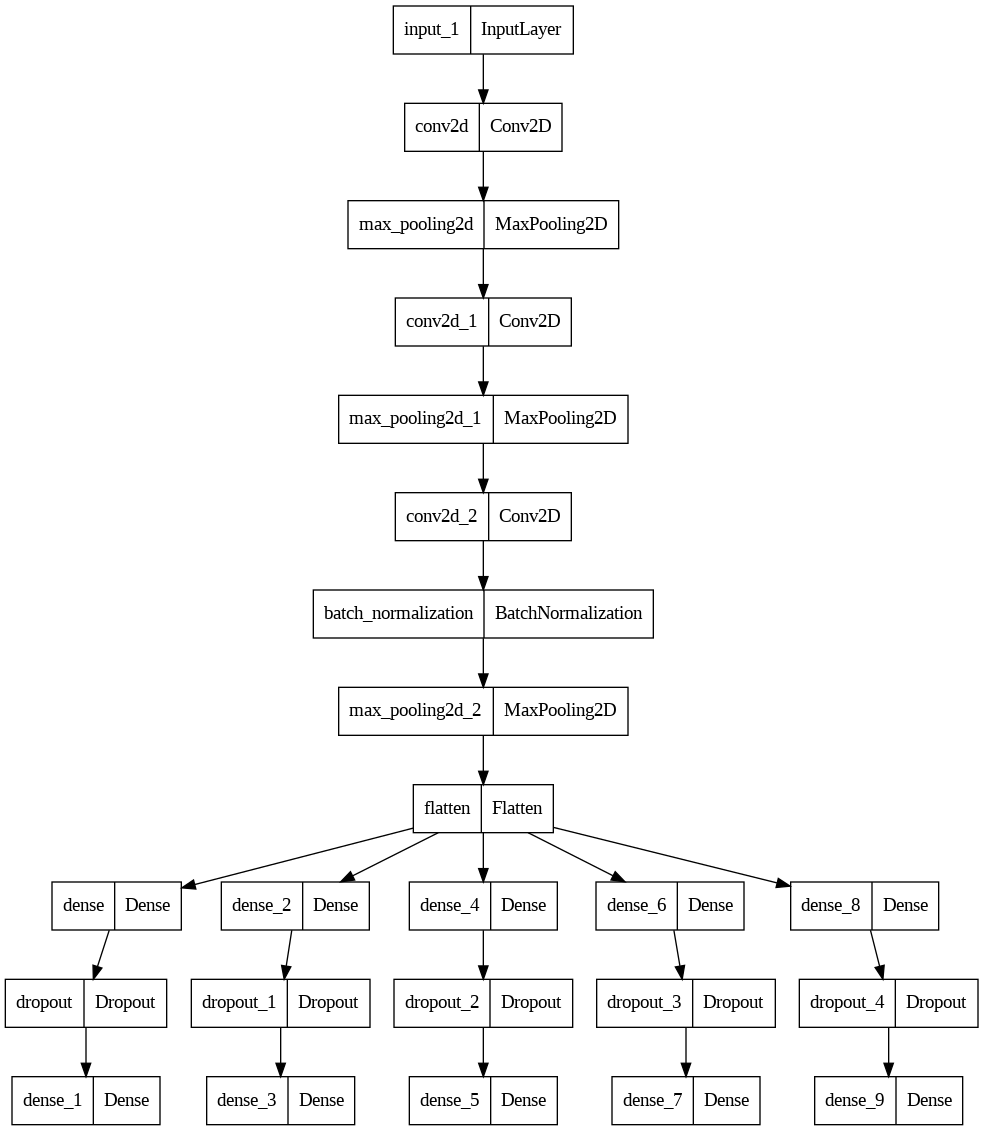

In [ ]:
utils.plot_model(model)

In [ ]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 5s 40ms/step - loss: 17.8747 - dense_11_loss: 3.6525 - dense_13_loss: 3.6198 - dense_15_loss: 3.4464 - dense_17_loss: 3.5584 - dense_19_loss: 3.5975 - dense_11_accuracy: 0.0425 - dense_13_accuracy: 0.0451 - dense_15_accuracy: 0.0657 - dense_17_accuracy: 0.0554 - dense_19_accuracy: 0.0709 - val_loss: 17.5587 - val_dense_11_loss: 3.5693 - val_dense_13_loss: 3.5390 - val_dense_15_loss: 3.4196 - val_dense_17_loss: 3.5237 - val_dense_19_loss: 3.5070 - val_dense_11_accuracy: 0.0000e+00 - val_dense_13_accuracy: 0.0464 - val_dense_15_accuracy: 0.0361 - val_dense_17_accuracy: 0.0567 - val_dense_19_accuracy: 0.0464
Epoch 2/30
25/25 [==============================] - 0s 16ms/step - loss: 16.8206 - dense_11_loss: 3.5270 - dense_13_loss: 3.3370 - dense_15_loss: 3.2201 - dense_17_loss: 3.3313 - dense_19_loss: 3.4052 - dense_11_accuracy: 0.0735 - dense_13_accuracy: 0.0760 - dense_15_accuracy: 0.0670 - dense_17_accuracy: 0.0683 - dense_19_accuracy: 0

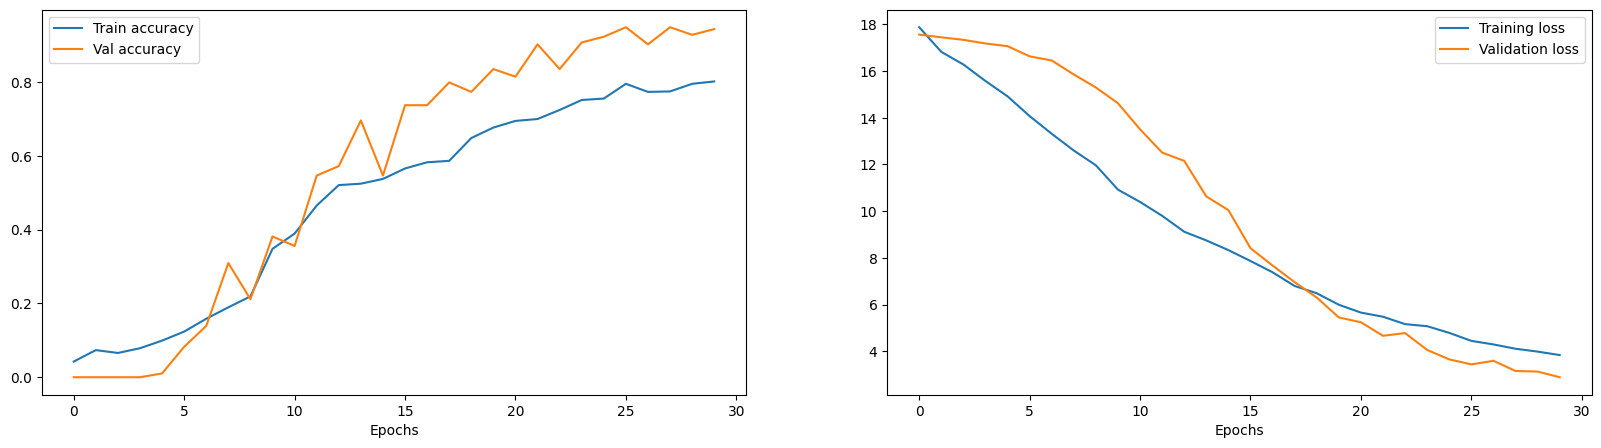

In [ ]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['dense_11_accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_dense_11_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(hist)
plt.show()

In [ ]:
model.save('captchaSolverr.keras')

In [ ]:
model=load_model('captchaSolverr.keras')

In [ ]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))

    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [ ]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 2s 61ms/step - loss: 2.3963 - dense_1_loss: 0.1566 - dense_3_loss: 0.2373 - dense_5_loss: 0.4991 - dense_7_loss: 0.8717 - dense_9_loss: 0.6316 - dense_1_accuracy: 0.9800 - dense_3_accuracy: 0.9500 - dense_5_accuracy: 0.8400 - dense_7_accuracy: 0.7200 - dense_9_accuracy: 0.8300
Test Loss and accuracy: [2.3962929248809814, 0.1566208004951477, 0.23728962242603302, 0.4990965723991394, 0.871663510799408, 0.6316224336624146, 0.9800000190734863, 0.949999988079071, 0.8399999737739563, 0.7200000286102295, 0.8299999833106995]


In [ ]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('samples/8n5p3.png'))
print(predict('samples/f2m8n.png'))
print(predict('samples/dce8y.png'))
print(predict('samples/3eny7.png'))
print(predict('samples/npxb7.png'))

1/1 [==============================] - 0s 252ms/step
8n5p3
1/1 [==============================] - 0s 28ms/step
f2m8n
1/1 [==============================] - 0s 25ms/step
dce8y
1/1 [==============================] - 0s 25ms/step
3eny7
1/1 [==============================] - 0s 29ms/step
npxb7


In [ ]:
!ls

 1A7ug.png				 captcha_image.png      esad.ipynb	 samples
 5zcvm.png				 captchaSolver.h5       kaggle		 Untitled0.ipynb
 bucokiyi.ipynb				 captchaSolver.ipynb    modelo.pkl
 building-a-captcha-ocr-in-tf2-0.ipynb	 captchaSolver.keras    my_model.keras
 captchaCreator.py			'Copy of captcha_ocr'   perturbed


In [ ]:
!pip install captcha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 2.2 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
Predicted Captcha = ec6pm
1/1 [==============================] - 0s 67ms/step
40
ec6pm
1/1 [==============================] - 0s 55ms/step
Predicted Captcha = ddxpp
1/1 [==============================] - 0s 69ms/step
41
ddxpp
1/1 [==============================] - 0s 72ms/step
Predicted Captcha = 8w754
1/1 [==============================] - 0s 77ms/step
42
8w754
1/1 [==============================] - 0s 41ms/step
Predicted Captcha = 4ycex
1/1 [==============================] - 0s 51ms/step
43
4ycex
1/1 [==============================] - 0s 78ms/step
Predicted Captcha = de45x
1/1 [==============================] - 0s 82ms/step
44
de45x
1/1 [==============================] - 0s 34ms/step
Predicted Captcha = 658xe
1/1 [==============================] - 0s 59ms/step
45
658xe
1/1 [==============================] - 0s 80ms/step
Predicted Captcha = dn2ym
1/1 [==============================] - 0s 40ms/step
46
dn2ym
1/1 [=======================

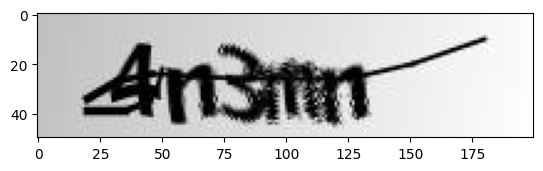

In [ ]:
#testing
c=0
total = 0
for i, pic in enumerate(os.listdir('samples')):


            img = cv2.imread(os.path.join('samples', pic), cv2.IMREAD_GRAYSCALE)
            print("Predicted Captcha =",predict(os.path.join('samples',pic)))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            pr=predict(os.path.join('samples',pic))
            pic_target = pic[:-4]
            if pr==pic_target:
                c=c+1
                print(c)
            total += 1
            print(pic_target)
print((c/total)*100)

In [ ]:
#SALT and PEPPER
def sp_noise(image, prob):
    output = np.zeros(image.shape, np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif 1 - rdn < prob:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [ ]:
!python add_salt_and_pepper.py

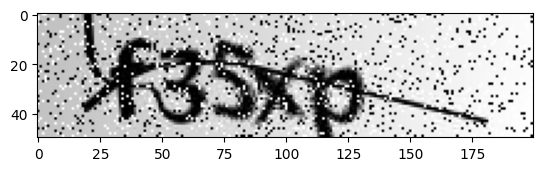

In [ ]:
#Lets test an unknown captcha
#preview
%matplotlib inline
import matplotlib.pyplot as plt
img=cv2.imread('perturbed/perturbed_f35xp.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

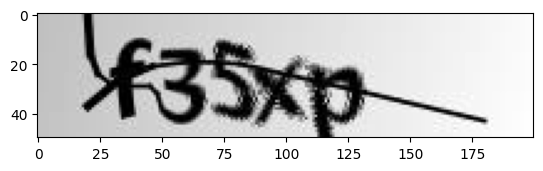

In [ ]:
#Lets test an unknown captcha
#preview
%matplotlib inline
import matplotlib.pyplot as plt
img=cv2.imread('samples/f35xp.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Lets Predict By Model
print("Predicted Captcha =",predict('samples/f35xp.png'))

1/1 [==============================] - 0s 27ms/step
Predicted Captcha = f35xp


In [ ]:
#Lets Predict By Model
print("Predicted Captcha =",predict('perturbed/perturbed_f35xp.png'))

1/1 [==============================] - 0s 27ms/step
Predicted Captcha = f35xp


In [ ]:
!ls

 1A7ug.png				 captcha_image.png      esad.ipynb	'perturbed (1)'
 5zcvm.png				 captchaSolver.h5       kaggle		 samples
 bucokiyi.ipynb				 captchaSolver.ipynb    modelo.pkl	 Untitled0.ipynb
 building-a-captcha-ocr-in-tf2-0.ipynb	 captchaSolver.keras    my_model.keras
 captchaCreator.py			'Copy of captcha_ocr'   perturbed


['perturbed_6c3p5.png', 'perturbed_enpw2.png', 'perturbed_cb8cf.png', 'perturbed_68x48.png', 'perturbed_5wddw.png', 'perturbed_28348.png', 'perturbed_3bfnd.png', 'perturbed_ddcne.png', 'perturbed_3fbxd.png', 'perturbed_6ecbn.png', 'perturbed_4nnf3.png', 'perturbed_6f857.png', 'perturbed_cg5dd.png', 'perturbed_d236n.png', 'perturbed_cdfen.png', 'perturbed_dbpcd.png', 'perturbed_24f6w.png', 'perturbed_b26nd.png', 'perturbed_dn26n.png', 'perturbed_ccf2w.png', 'perturbed_d378n.png', 'perturbed_244e2.png', 'perturbed_c4527.png', 'perturbed_4743p.png', 'perturbed_b5dn4.png', 'perturbed_efb3f.png', 'perturbed_bgxcd.jpg', 'perturbed_b3xpn.png', 'perturbed_7634y.png', 'perturbed_f753f.png', 'perturbed_8bbw8.png', 'perturbed_cwgyx.png', 'perturbed_245y5.png', 'perturbed_dpbyd.png', 'perturbed_dmx8p.png', 'perturbed_66wp5.png', 'perturbed_7d44m.png', 'perturbed_e46yw.png', 'perturbed_5yxgp.png', 'perturbed_ec6pm.png', 'perturbed_ddxpp.jpg', 'perturbed_8w754.png', 'perturbed_4ycex.png', 'perturbed

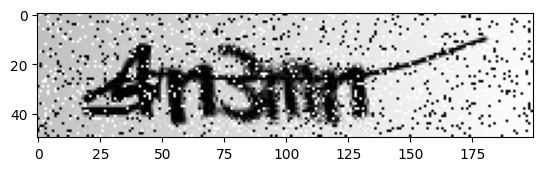

In [ ]:
c = 0
total_perturbed_images = 0
print(os.listdir('perturbed'))
for i, perturbed_pic in enumerate(os.listdir('perturbed')):

      perturbed_img = cv2.imread(os.path.join('perturbed', perturbed_pic), cv2.IMREAD_GRAYSCALE)

      # Assuming the 'predict' function takes an image path and returns the predicted captcha
      predicted_captcha = predict(os.path.join('perturbed', perturbed_pic))

      plt.imshow(perturbed_img, cmap=plt.get_cmap('gray'))

      pic_target = perturbed_pic[10:-4]  # Remove the 'perturbed_' prefix and file extension
      print("Predicted Captcha =", predicted_captcha)
      print("Actual Captcha =", pic_target)

      if predicted_captcha == pic_target:
          c += 1
          print(c)

      total_perturbed_images += 1

accuracy = (c / total_perturbed_images) * 100
print(f"Accuracy on perturbed images: {accuracy}%")

In [ ]:
def generate_noisy_data(original_X, noise_level=0.025):
    noisy_X = original_X + noise_level * np.random.normal(0, 1, original_X.shape)
    noisy_X = np.clip(noisy_X, 0, 1)  # Ensure values are within the valid range [0, 1]
    return noisy_X

In [ ]:
!python add_sp_noise.py

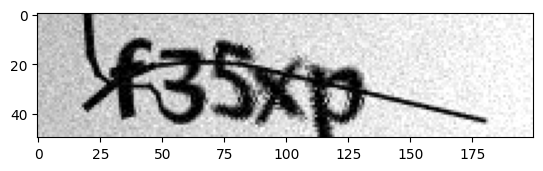

In [ ]:
#Lets test an unknown captcha
#preview
%matplotlib inline
import matplotlib.pyplot as plt
img=cv2.imread('noisy/noisy_f35xp.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Lets Predict By Model
print("Predicted Captcha =",predict('noisy/noisy_f35xp.png'))

1/1 [==============================] - 0s 29ms/step
Predicted Captcha = f35xp


['noisy_6c3p5.png', 'noisy_enpw2.png', 'noisy_cb8cf.png', 'noisy_68x48.png', 'noisy_5wddw.png', 'noisy_28348.png', 'noisy_3bfnd.png', 'noisy_ddcne.png', 'noisy_3fbxd.png', 'noisy_6ecbn.png', 'noisy_4nnf3.png', 'noisy_6f857.png', 'noisy_cg5dd.png', 'noisy_d236n.png', 'noisy_cdfen.png', 'noisy_dbpcd.png', 'noisy_24f6w.png', 'noisy_b26nd.png', 'noisy_dn26n.png', 'noisy_ccf2w.png', 'noisy_d378n.png', 'noisy_244e2.png', 'noisy_c4527.png', 'noisy_4743p.png', 'noisy_b5dn4.png', 'noisy_efb3f.png', 'noisy_bgxcd.jpg', 'noisy_b3xpn.png', 'noisy_7634y.png', 'noisy_f753f.png', 'noisy_8bbw8.png', 'noisy_cwgyx.png', 'noisy_245y5.png', 'noisy_dpbyd.png', 'noisy_dmx8p.png', 'noisy_66wp5.png', 'noisy_7d44m.png', 'noisy_e46yw.png', 'noisy_5yxgp.png', 'noisy_ec6pm.png', 'noisy_ddxpp.jpg', 'noisy_8w754.png', 'noisy_4ycex.png', 'noisy_de45x.png', 'noisy_658xe.png', 'noisy_dn2ym.png', 'noisy_264m5.png', 'noisy_46mbm.png', 'noisy_8e32m.png', 'noisy_exycn.png', 'noisy_64b3p.png', 'noisy_6mege.png', 'noisy_7gmf

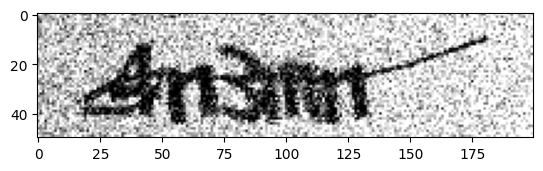

In [ ]:
c = 0
total_perturbed_images = 0
print(os.listdir('noisy'))
for i, perturbed_pic in enumerate(os.listdir('noisy')):

      perturbed_img = cv2.imread(os.path.join('noisy', perturbed_pic), cv2.IMREAD_GRAYSCALE)

      # Assuming the 'predict' function takes an image path and returns the predicted captcha
      predicted_captcha = predict(os.path.join('noisy', perturbed_pic))

      plt.imshow(perturbed_img, cmap=plt.get_cmap('gray'))

      pic_target = perturbed_pic[6:-4]  # Remove the 'perturbed_' prefix and file extension
      print("Predicted Captcha =", predicted_captcha)
      print("Actual Captcha =", pic_target)

      if predicted_captcha == pic_target:
          c += 1
          print(c)

      total_perturbed_images += 1

accuracy = (c / total_perturbed_images) * 100
print(f"Accuracy on noisy images: {accuracy}%")

In [ ]:
# import the necessary packages
from tensorflow.keras.losses import MSE
import tensorflow as tf
def generate_image_adversary_FGSM(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)
 	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)
		# use our model to make predictions on the input image and
		# then compute the loss
		pred = model(image)
		loss = MSE(label, pred)
  	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient)
	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()
	# return the image adversary to the calling function
	return adversary

1/1 [==============================] - 0s 24ms/step


<ipython-input-17-17385dfe8fdb>:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if y_pred == a:


1/1 [==============================] - 0s 26ms/step
Acc:  0.0


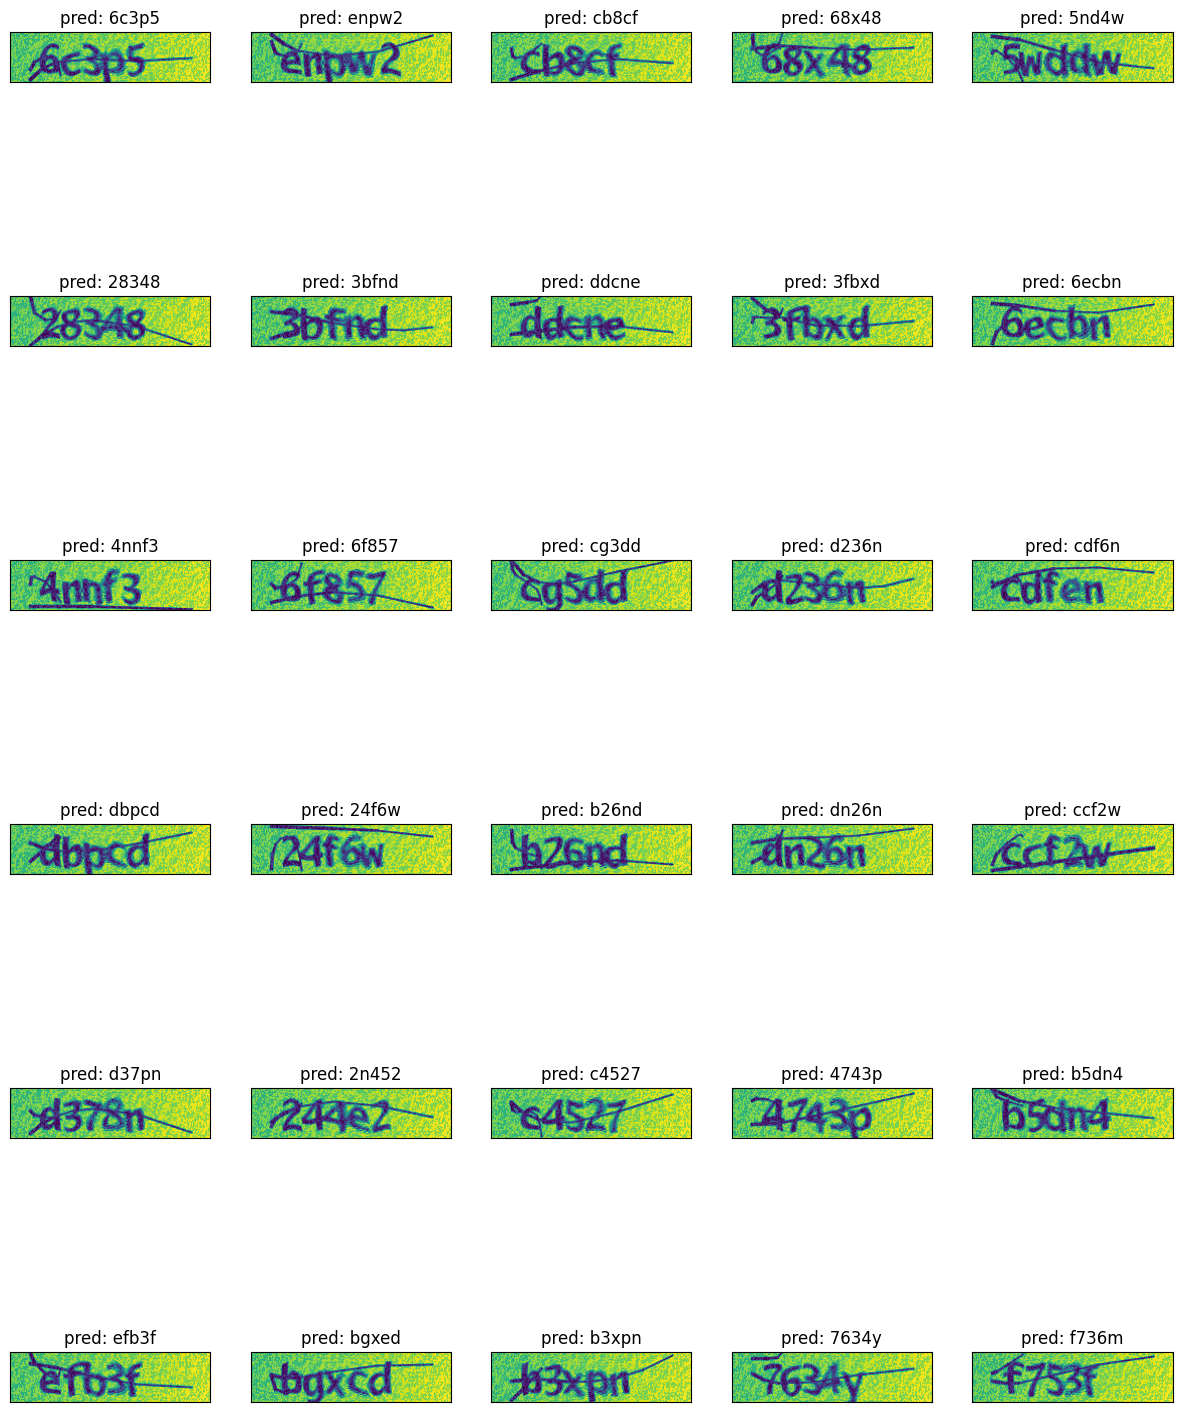

In [ ]:
import math

"""def format_y_label(y):

    str_result = ''
    for i in y:

        i = int(i.numpy())
        str_result += symbols[i]
    return str_result"""
def format_y_label(y):
    return ''.join(map(lambda x: symbols[int(x)], y))
def format_y_pred(y):

    str_result = ''
    for i in y:
        str_result += symbols[int(i)]
    return str_result



adv_list = np.zeros((25,50,200,1))
#label_list = np.zeros(())
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
true_count = 0
flat_counter = 0
for i in range(30):
    image = X[i]
    label = y_reshaped[i]

    a = np.zeros(5)
    for _ in range(5):
      a[_] = np.nonzero(label[_])[0][0]
    adversary = generate_image_adversary_FGSM(model,np.array([image]), label, eps=0.1)

    y_pred = model.predict(adversary)
    if i < 25:
      adv_list[i] = adversary
    label = format_y_pred(a)
    adversary=adversary.reshape(50,200,1)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = y_pred.numpy()

    y_pred = format_y_pred(y_pred)
    ax = axes.flat[flat_counter]
    ax.imshow(adversary)
    ax.set_title('pred: %s' % y_pred)
    ax.set_xticks([])
    ax.set_yticks([])
    flat_counter += 1
    if y_pred == a:
      true_count += 1

acc = 100* true_count / 30
print("Acc: ", acc)
plt.show()

Now Train the model by adding some adverserial data to its training data and see the difference.

In [ ]:
def preprocess_data_new():
    n_samples = len(os.listdir('perturbed_samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('perturbed_samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('perturbed_samples', pic), cv2.IMREAD_GRAYSCALE)
        print(img.shape)
        if pic.startswith("Copy of per") and len(pic) >= 14:
            pic_target = pic[18:23]
            print(pic_target)
        elif pic.startswith("Copy of noi") and len(pic) >= 14:
            pic_target = pic[14:19]
            print(pic_target)
        else:
            pic_target = pic[:5]
            print(pic_target)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs

    # Return final data
    return X, y

X, y = preprocess_data_new()
print(len(X))
"""X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]"""

(50, 200)
gnbn4
(50, 200)
6bnnm
(50, 200)
fdpgd
(50, 200)
g3ex3
(50, 200)
mye68
(50, 200)
ef4mn
(50, 200)
pgm2e
(50, 200)
yemy4
(50, 200)
cb8cf
(50, 200)
mmg38
(50, 200)
pnmxf
(50, 200)
e3ndn
(50, 200)
n7meb
(50, 200)
w75w8
(50, 200)
yyn57
(50, 200)
fp762
(50, 200)
4cn7b
(50, 200)
34b84
(50, 200)
pwn5e
(50, 200)
dmx8p
(50, 200)
m3wfw
(50, 200)
5pm6b
(50, 200)
5ng6e
(50, 200)
c2g4d
(50, 200)
bcwnn
(50, 200)
fg8n4
(50, 200)
md344
(50, 200)
b2g8e
(50, 200)
cfc56
(50, 200)
b4y5x
(50, 200)
c2fb7
(50, 200)
44fyb
(50, 200)
ggd7m
(50, 200)
gnf85
(50, 200)
2enf4
(50, 200)
m5meg
(50, 200)
fcmem
(50, 200)
4w76g
(50, 200)
yd3m3
(50, 200)
47e4p
(50, 200)
2yggg
(50, 200)
xcf88
(50, 200)
4ycex
(50, 200)
pe4xn
(50, 200)
6end3
(50, 200)
8c2wy
(50, 200)
ncfgb
(50, 200)
nxx25
(50, 200)
678w3
(50, 200)
fpw76
(50, 200)
dyp7n
(50, 200)
ddnpf
(50, 200)
ybfx6
(50, 200)
74eyg
(50, 200)
mbf58
(50, 200)
e46pd
(50, 200)
2ycn8
(50, 200)
5bnd7
(50, 200)
6fg8c
(50, 200)
b685n
(50, 200)
n5w5g
(50, 200)
fbp2c
(50, 200

'X_train, y_train = X[:970], y[:, :970]\nX_test, y_test = X[970:], y[:, 970:]'

In [ ]:
X_train, y_train = X[100:], y[:,100:]
X_test, y_test = X[:100], y[:, :100]

In [ ]:
model2=create_model();
model2.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']   

In [ ]:
hist = model2.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
30/30 [==============================] - 12s 47ms/step - loss: 17.8494 - dense_1_loss: 3.6243 - dense_3_loss: 3.5570 - dense_5_loss: 3.5387 - dense_7_loss: 3.5381 - dense_9_loss: 3.5913 - dense_1_accuracy: 0.0524 - dense_3_accuracy: 0.0662 - dense_5_accuracy: 0.0652 - dense_7_accuracy: 0.0609 - dense_9_accuracy: 0.0502 - val_loss: 2.5571 - val_dense_1_loss: 0.5156 - val_dense_3_loss: 0.5129 - val_dense_5_loss: 0.5119 - val_dense_7_loss: 0.5060 - val_dense_9_loss: 0.5107 - val_dense_1_accuracy: 0.0214 - val_dense_3_accuracy: 0.0043 - val_dense_5_accuracy: 0.0085 - val_dense_7_accuracy: 0.0214 - val_dense_9_accuracy: 0.0085
Epoch 2/30
30/30 [==============================] - 0s 14ms/step - loss: 16.8459 - dense_1_loss: 3.4905 - dense_3_loss: 3.3171 - dense_5_loss: 3.3163 - dense_7_loss: 3.3308 - dense_9_loss: 3.3913 - dense_1_accuracy: 0.0449 - dense_3_accuracy: 0.0748 - dense_5_accuracy: 0.0684 - dense_7_accuracy: 0.0812 - dense_9_accuracy: 0.0620 - val_loss: 2.5348 - val_den

In [ ]:
model.save('captchaSolverr2.keras')

In [ ]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 2s 83ms/step - loss: 0.9446 - dense_1_loss: 0.0486 - dense_3_loss: 0.1427 - dense_5_loss: 0.2148 - dense_7_loss: 0.3950 - dense_9_loss: 0.1433 - dense_1_accuracy: 0.9800 - dense_3_accuracy: 0.9700 - dense_5_accuracy: 0.9300 - dense_7_accuracy: 0.9000 - dense_9_accuracy: 0.9800
Test Loss and accuracy: [0.9445638060569763, 0.04862973839044571, 0.14271368086338043, 0.21484294533729553, 0.39503031969070435, 0.14334706962108612, 0.9800000190734863, 0.9700000286102295, 0.9300000071525574, 0.8999999761581421, 0.9800000190734863]


In [ ]:
# Define function to predict captcha
def predict2(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model2.predict(img[np.newaxis, :, :, np.newaxis]))

    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
34
dmx8p
1/1 [==============================] - 0s 35ms/step
Predicted Captcha = 66wp5
1/1 [==============================] - 0s 29ms/step
35
66wp5
1/1 [==============================] - 0s 30ms/step
Predicted Captcha = 7d44m
1/1 [==============================] - 0s 35ms/step
36
7d44m
1/1 [==============================] - 0s 35ms/step
Predicted Captcha = e46yw
1/1 [==============================] - 0s 39ms/step
37
e46yw
1/1 [==============================] - 0s 30ms/step
Predicted Captcha = 5yxgg
1/1 [==============================] - 0s 35ms/step
38
5yxgp
1/1 [==============================] - 0s 33ms/step
Predicted Captcha = ec6pm
1/1 [==============================] - 0s 33ms/step
39
ec6pm
1/1 [==============================] - 0s 28ms/step
Predicted Captcha = ddxpp
1/1 [==============================] - 0s 32ms/step
40
ddxpp
1/1 [==============================] - 0s 33ms/step
Pr

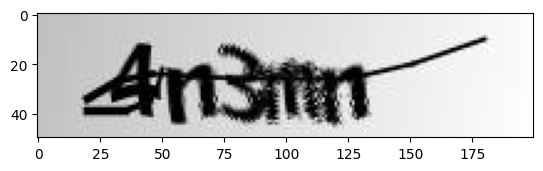

In [ ]:
#testing
c=0
total = 0
for i, pic in enumerate(os.listdir('samples')):


            img = cv2.imread(os.path.join('samples', pic), cv2.IMREAD_GRAYSCALE)
            print("Predicted Captcha =",predict2(os.path.join('samples',pic)))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            pr=predict(os.path.join('samples',pic))
            pic_target = pic[:-4]
            if pr==pic_target:
                c=c+1
                print(c)
            total += 1
            print(pic_target)
print((c/total)*100)

['perturbed_6c3p5.png', 'perturbed_enpw2.png', 'perturbed_cb8cf.png', 'perturbed_68x48.png', 'perturbed_5wddw.png', 'perturbed_28348.png', 'perturbed_3bfnd.png', 'perturbed_ddcne.png', 'perturbed_3fbxd.png', 'perturbed_6ecbn.png', 'perturbed_4nnf3.png', 'perturbed_6f857.png', 'perturbed_cg5dd.png', 'perturbed_d236n.png', 'perturbed_cdfen.png', 'perturbed_dbpcd.png', 'perturbed_24f6w.png', 'perturbed_b26nd.png', 'perturbed_dn26n.png', 'perturbed_ccf2w.png', 'perturbed_d378n.png', 'perturbed_244e2.png', 'perturbed_c4527.png', 'perturbed_4743p.png', 'perturbed_b5dn4.png', 'perturbed_efb3f.png', 'perturbed_bgxcd.jpg', 'perturbed_b3xpn.png', 'perturbed_7634y.png', 'perturbed_f753f.png', 'perturbed_8bbw8.png', 'perturbed_cwgyx.png', 'perturbed_245y5.png', 'perturbed_dpbyd.png', 'perturbed_dmx8p.png', 'perturbed_66wp5.png', 'perturbed_7d44m.png', 'perturbed_e46yw.png', 'perturbed_5yxgp.png', 'perturbed_ec6pm.png', 'perturbed_ddxpp.jpg', 'perturbed_8w754.png', 'perturbed_4ycex.png', 'perturbed

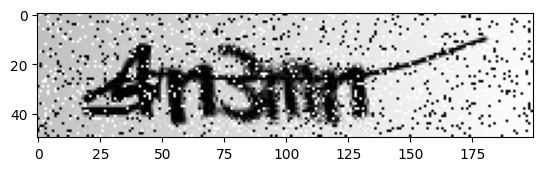

In [ ]:
c = 0
total_perturbed_images = 0
print(os.listdir('perturbed'))
for i, perturbed_pic in enumerate(os.listdir('perturbed')):

      perturbed_img = cv2.imread(os.path.join('perturbed', perturbed_pic), cv2.IMREAD_GRAYSCALE)

      # Assuming the 'predict' function takes an image path and returns the predicted captcha
      predicted_captcha = predict2(os.path.join('perturbed', perturbed_pic))

      plt.imshow(perturbed_img, cmap=plt.get_cmap('gray'))

      pic_target = perturbed_pic[10:-4]  # Remove the 'perturbed_' prefix and file extension
      print("Predicted Captcha =", predicted_captcha)
      print("Actual Captcha =", pic_target)

      if predicted_captcha == pic_target:
          c += 1
          print(c)

      total_perturbed_images += 1

accuracy = (c / total_perturbed_images) * 100
print(f"Accuracy on perturbed images: {accuracy}%")

['noisy_6c3p5.png', 'noisy_enpw2.png', 'noisy_cb8cf.png', 'noisy_68x48.png', 'noisy_5wddw.png', 'noisy_28348.png', 'noisy_3bfnd.png', 'noisy_ddcne.png', 'noisy_3fbxd.png', 'noisy_6ecbn.png', 'noisy_4nnf3.png', 'noisy_6f857.png', 'noisy_cg5dd.png', 'noisy_d236n.png', 'noisy_cdfen.png', 'noisy_dbpcd.png', 'noisy_24f6w.png', 'noisy_b26nd.png', 'noisy_dn26n.png', 'noisy_ccf2w.png', 'noisy_d378n.png', 'noisy_244e2.png', 'noisy_c4527.png', 'noisy_4743p.png', 'noisy_b5dn4.png', 'noisy_efb3f.png', 'noisy_bgxcd.jpg', 'noisy_b3xpn.png', 'noisy_7634y.png', 'noisy_f753f.png', 'noisy_8bbw8.png', 'noisy_cwgyx.png', 'noisy_245y5.png', 'noisy_dpbyd.png', 'noisy_dmx8p.png', 'noisy_66wp5.png', 'noisy_7d44m.png', 'noisy_e46yw.png', 'noisy_5yxgp.png', 'noisy_ec6pm.png', 'noisy_ddxpp.jpg', 'noisy_8w754.png', 'noisy_4ycex.png', 'noisy_de45x.png', 'noisy_658xe.png', 'noisy_dn2ym.png', 'noisy_264m5.png', 'noisy_46mbm.png', 'noisy_8e32m.png', 'noisy_exycn.png', 'noisy_64b3p.png', 'noisy_6mege.png', 'noisy_7gmf

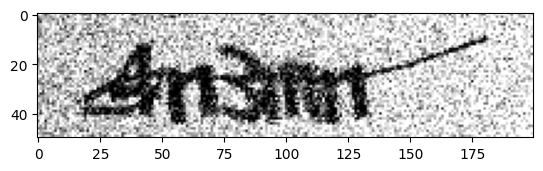

In [ ]:
c = 0
total_perturbed_images = 0
print(os.listdir('noisy'))
for i, perturbed_pic in enumerate(os.listdir('noisy')):

      perturbed_img = cv2.imread(os.path.join('noisy', perturbed_pic), cv2.IMREAD_GRAYSCALE)

      # Assuming the 'predict' function takes an image path and returns the predicted captcha
      predicted_captcha = predict2(os.path.join('noisy', perturbed_pic))

      plt.imshow(perturbed_img, cmap=plt.get_cmap('gray'))

      pic_target = perturbed_pic[6:-4]  # Remove the 'perturbed_' prefix and file extension
      print("Predicted Captcha =", predicted_captcha)
      print("Actual Captcha =", pic_target)

      if predicted_captcha == pic_target:
          c += 1
          print(c)

      total_perturbed_images += 1

accuracy = (c / total_perturbed_images) * 100
print(f"Accuracy on noisy images: {accuracy}%")